We built an end-to-end AML pipeline combining unsupervised GraphSAGE embeddings with a supervised XGBoost classifier, achieving strong ranking performance on highly imbalanced data.

In [1]:
# Reproducibility
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
from pathlib import Path

import pandas as pd

repo_root = Path("/Users/sahilsingh/Documents/Hackathon/lab/Hackathons/ING-Global-Hackathon-2026")

# Paths 
amlsim_root = repo_root / "aml-validator-engine" / "01_data_engine" / "amlsim"
tx_log_path = amlsim_root / "outputs" / "aml_hackathon_v1" / "tx_log.csv"
accounts_path = amlsim_root / "tmp" / "aml_hackathon_v1" / "accounts.csv"

# Load datasets
print("Loading tx_log.csv...")
tx_log_df = pd.read_csv(tx_log_path)
print("Loading accounts.csv...")
accounts_df = pd.read_csv(accounts_path)

# Display shapes, columns, and sample rows
print("\nTX_LOG")
print("Shape:", tx_log_df.shape)
print("Columns:", list(tx_log_df.columns))
print("Sample rows:")
print(tx_log_df.head())

print("\nACCOUNTS")
print("Shape:", accounts_df.shape)
print("Columns:", list(accounts_df.columns))
print("Sample rows:")
print(accounts_df.head())


Loading tx_log.csv...
Loading accounts.csv...

TX_LOG
Shape: (47295, 11)
Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrig', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isSAR', 'alertID']
Sample rows:
   step      type   amount  nameOrig  oldbalanceOrig  newbalanceOrig  \
0     0  TRANSFER  4521.49       982        79229.07        74707.58   
1     0  TRANSFER  1737.92      1107        54897.73        53159.81   
2     0  TRANSFER  5078.78       659        64109.98        59031.19   
3     0  TRANSFER  9396.15       620        85630.00        76233.84   
4     0  TRANSFER  5647.71       504        59028.73        53381.01   

   nameDest  oldbalanceDest  newbalanceDest  isSAR  alertID  
0        23        99168.24       103689.73      0       -1  
1       104        80478.67        82216.59      0       -1  
2       107        99235.77       104314.56      0       -1  
3        10        92168.75       101564.91      0       -1  
4       103        

In [3]:
# Identify node, sender, and receiver columns
account_id_col = "ACCOUNT_ID"
sender_col = "nameOrig"
receiver_col = "nameDest"

print("Account ID column used for nodes:", account_id_col)
print("Sender column in tx_log.csv:", sender_col)
print("Receiver column in tx_log.csv:", receiver_col)

# Verify nameOrig/nameDest values exist in accounts.csv
accounts_ids = set(accounts_df[account_id_col].astype(str))
tx_sender_ids = set(tx_log_df[sender_col].astype(str))
tx_receiver_ids = set(tx_log_df[receiver_col].astype(str))

tx_ids = tx_sender_ids | tx_receiver_ids
missing_in_accounts = sorted(tx_ids - accounts_ids)

print("\nAccount coverage check")
print("Unique accounts in accounts.csv:", len(accounts_ids))
print("Unique accounts referenced in tx_log.csv:", len(tx_ids))
print("Missing/unmatched accounts:", len(missing_in_accounts))
if missing_in_accounts:
    print("Sample missing IDs:", missing_in_accounts[:10])


Account ID column used for nodes: ACCOUNT_ID
Sender column in tx_log.csv: nameOrig
Receiver column in tx_log.csv: nameDest

Account coverage check
Unique accounts in accounts.csv: 1446
Unique accounts referenced in tx_log.csv: 1354
Missing/unmatched accounts: 0


In [4]:
import torch

# Map ACCOUNT_ID to contiguous node indices
account_ids = accounts_df[account_id_col].astype(str).unique().tolist()
account_id_to_idx = {account_id: idx for idx, account_id in enumerate(account_ids)}

# Convert sender/receiver IDs to indices
src = tx_log_df[sender_col].astype(str).map(account_id_to_idx)
dst = tx_log_df[receiver_col].astype(str).map(account_id_to_idx)

# Drop any rows that failed to map (should be none based on prior check)
valid_mask = src.notna() & dst.notna()
src_idx = src[valid_mask].astype(int).to_numpy()
dst_idx = dst[valid_mask].astype(int).to_numpy()

# Build directed edge_index tensor for torch-geometric
edge_index = torch.tensor([src_idx, dst_idx], dtype=torch.long)

print("Nodes:", len(account_ids))
print("Edges:", edge_index.size(1))


Nodes: 1446
Edges: 47295


/var/folders/dw/g3ypc2555pzgdfgppj2cjj8w0000gn/T/ipykernel_37956/1406979634.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  edge_index = torch.tensor([src_idx, dst_idx], dtype=torch.long)


In [5]:
# Load accounts.csv and build feature matrix
accounts_df = pd.read_csv(accounts_path)
accounts_features_df = accounts_df.drop(columns=["ACCOUNT_ID", "CUSTOMER_ID", "IS_SAR"])

categorical_cols = accounts_features_df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
numerical_cols = accounts_features_df.select_dtypes(include=["number"]).columns.tolist()

print("Shape:", accounts_features_df.shape)
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)


Shape: (1446, 4)
Categorical columns: ['COUNTRY', 'ACCOUNT_TYPE', 'BANK_ID']
Numerical columns: ['INIT_BALANCE']


In [6]:
# Check unique values in categorical columns
for col in categorical_cols:
    uniques = accounts_features_df[col].unique()
    print(f"{col}: {len(uniques)} unique value(s) -> {uniques}")

COUNTRY: 1 unique value(s) -> ['US']
ACCOUNT_TYPE: 1 unique value(s) -> ['I']
BANK_ID: 1 unique value(s) -> ['bank']


In [7]:
# One-hot encode categorical columns
encoded_cats_df = pd.get_dummies(
    accounts_features_df[categorical_cols],
    columns=categorical_cols,
    dummy_na=False,
)

# Standardize numerical columns using mean/std (no sklearn)
num_df = accounts_features_df[numerical_cols].astype(float)
num_mean = num_df.mean()
num_std = num_df.std(ddof=0).replace(0, 1.0)
scaled_num_df = (num_df - num_mean) / num_std

# Concatenate encoded categorical and scaled numerical features
account_features_encoded_df = pd.concat(
    [encoded_cats_df, scaled_num_df],
    axis=1,
)

print("Encoded feature shape:", account_features_encoded_df.shape)
print("Encoded feature columns:", list(account_features_encoded_df.columns))


Encoded feature shape: (1446, 4)
Encoded feature columns: ['COUNTRY_US', 'ACCOUNT_TYPE_I', 'BANK_ID_bank', 'INIT_BALANCE']


In [8]:
# Align node features with node index mapping
accounts_indexed_df = accounts_df.copy()
accounts_indexed_df[account_id_col] = accounts_indexed_df[account_id_col].astype(str)
accounts_indexed_df = accounts_indexed_df.set_index(account_id_col)

# account_ids is ordered by account_id_to_idx construction
aligned_features_df = accounts_indexed_df.reindex(account_ids)

num_nodes = len(account_ids)
print("Aligned feature rows:", aligned_features_df.shape[0])
print("Num nodes:", num_nodes)
print("Row count matches:", aligned_features_df.shape[0] == num_nodes)

print("\nFirst 5 rows (aligned):")
print(aligned_features_df.head())


Aligned feature rows: 1446
Num nodes: 1446
Row count matches: True

First 5 rows (aligned):
           CUSTOMER_ID  INIT_BALANCE COUNTRY ACCOUNT_TYPE  IS_SAR BANK_ID
ACCOUNT_ID                                                               
0                  C_0      96646.86      US            I   False    bank
1                  C_1      80707.36      US            I   False    bank
2                  C_2      52101.10      US            I   False    bank
3                  C_3      90324.40      US            I   False    bank
4                  C_4      91267.86      US            I   False    bank


In [9]:
# Align encoded feature matrix to node index mapping
account_features_encoded_df = account_features_encoded_df.copy()
account_features_encoded_df.index = accounts_df[account_id_col].astype(str)

aligned_encoded_features_df = account_features_encoded_df.reindex(account_ids)

print("Aligned encoded feature rows:", aligned_encoded_features_df.shape[0])
print("Num nodes:", num_nodes)
print("Row count matches:", aligned_encoded_features_df.shape[0] == num_nodes)

print("\nFirst 5 rows (aligned encoded features):")
print(aligned_encoded_features_df.head())


Aligned encoded feature rows: 1446
Num nodes: 1446
Row count matches: True

First 5 rows (aligned encoded features):
            COUNTRY_US  ACCOUNT_TYPE_I  BANK_ID_bank  INIT_BALANCE
ACCOUNT_ID                                                        
0                 True            True          True      1.487079
1                 True            True          True      0.382497
2                 True            True          True     -1.599869
3                 True            True          True      1.048942
4                 True            True          True      1.114323


In [10]:
# Convert aligned encoded features to float and build torch tensor
x_df = aligned_encoded_features_df.replace({True: 1.0, False: 0.0}).astype(float)
x = torch.tensor(x_df.to_numpy(), dtype=torch.float)

print("x.shape:", x.shape)
print("x.dtype:", x.dtype)


x.shape: torch.Size([1446, 4])
x.dtype: torch.float32


/var/folders/dw/g3ypc2555pzgdfgppj2cjj8w0000gn/T/ipykernel_37956/3204892551.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_df = aligned_encoded_features_df.replace({True: 1.0, False: 0.0}).astype(float)


In [11]:
print(type(x))
print(type(edge_index))

print("x shape:", x.shape)
print("edge_index shape:", edge_index.shape)


<class 'torch.Tensor'>
<class 'torch.Tensor'>
x shape: torch.Size([1446, 4])
edge_index shape: torch.Size([2, 47295])


In [12]:
import torch
from torch_geometric.data import Data

# edge_index: shape [2, num_edges]
# x: shape [num_nodes, num_features]

data = Data(
    x=x,
    edge_index=edge_index
)

print(data)

/Users/sahilsingh/Documents/Hackathon/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data(x=[1446, 4], edge_index=[2, 47295])


In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [14]:
from torch_geometric.utils import negative_sampling

def unsupervised_loss(z, edge_index):
    # Positive edges
    src, dst = edge_index
    pos_score = (z[src] * z[dst]).sum(dim=1)
    pos_loss = -torch.log(torch.sigmoid(pos_score) + 1e-15).mean()

    # Negative edges
    neg_edge_index = negative_sampling(
        edge_index=edge_index,
        num_nodes=z.size(0),
        num_neg_samples=edge_index.size(1)
    )
    neg_src, neg_dst = neg_edge_index
    neg_score = (z[neg_src] * z[neg_dst]).sum(dim=1)
    neg_loss = -torch.log(1 - torch.sigmoid(neg_score) + 1e-15).mean()

    return pos_loss + neg_loss

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GraphSAGE(
    in_channels=data.num_node_features,
    hidden_channels=32,
    out_channels=32
).to(device)

data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(1, 101):
    optimizer.zero_grad()
    z = model(data.x, data.edge_index)
    loss = unsupervised_loss(z, data.edge_index)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")

Epoch 010, Loss: 1.4734
Epoch 020, Loss: 1.3583
Epoch 030, Loss: 1.3156
Epoch 040, Loss: 1.2990
Epoch 050, Loss: 1.2770
Epoch 060, Loss: 1.2499
Epoch 070, Loss: 1.2266
Epoch 080, Loss: 1.2062
Epoch 090, Loss: 1.1995
Epoch 100, Loss: 1.1934


In [16]:
model.eval()
with torch.no_grad():
    node_embeddings = model(data.x, data.edge_index)

print("Node embedding shape:", node_embeddings.shape)

Node embedding shape: torch.Size([1446, 32])


In [ ]:
import numpy as np

# Move embeddings to CPU numpy
emb_np = node_embeddings.cpu().numpy()

# Map node index -> embedding
idx_to_embedding = {
    idx: emb_np[idx] for idx in range(emb_np.shape[0])
}

# Map account_id -> node index (already exists)
# account_id_to_idx

# Build transaction-level dataset
tx_features = []
tx_labels = []

for _, row in tx_log_df.iterrows():
    src_id = str(row[sender_col])
    dst_id = str(row[receiver_col])

    src_idx = account_id_to_idx[src_id]
    dst_idx = account_id_to_idx[dst_id]

    src_emb = idx_to_embedding[src_idx]
    dst_emb = idx_to_embedding[dst_idx]

    # Basic transaction features
    tx_feat = [
        row["amount"],
        row["oldbalanceOrig"],
        row["newbalanceOrig"],
        row["oldbalanceDest"],
        row["newbalanceDest"]
    ]

    # Combine everything
    full_feat = np.concatenate([src_emb, dst_emb, tx_feat])
    tx_features.append(full_feat)
    tx_labels.append(row["isSAR"])

X_tx = np.vstack(tx_features)
y_tx = np.array(tx_labels)

print("Transaction feature matrix shape:", X_tx.shape)
print("Positive rate:", y_tx.mean())

Transaction feature matrix shape: (47295, 69)
Positive rate: 0.001141769743101808


In [ ]:
The dataset is highly imbalanced (~0.11% positive rate).
This means that predicting all transactions as non-SAR would already achieve ~99.9% accuracy, while completely failing to detect positive cases.

Therefore, accuracy is not a meaningful metric in this setting.


The further steps will be:
* Use XGBoost as the downstream classifier
* Incorporate class weighting to address severe class imbalance
* Train on transaction-level data enriched with:
    * Sender embeddings (32 features)
    * Receiver embeddings (32 features)
    * Raw transaction features


In [19]:
import sklearn
import xgboost
print("sklearn version:", sklearn.__version__)
print("xgboost version:", xgboost.__version__)


sklearn version: 1.7.2
xgboost version: 3.1.3


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_tx,
    y_tx,
    test_size=0.3,
    random_state=42,
    stratify=y_tx
)

print("Train positive rate:", y_train.mean())
print("Validation positive rate:", y_val.mean())

Train positive rate: 0.001147828188243823
Validation positive rate: 0.0011276340827401509


In [21]:
from xgboost import XGBClassifier

# Handle class imbalance
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()
print("scale_pos_weight:", scale_pos_weight)

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

scale_pos_weight: 870.2105263157895


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [22]:
from sklearn.metrics import roc_auc_score, classification_report

y_val_pred_proba = xgb_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_val, y_val_pred_proba))
print(classification_report(y_val, y_val_pred, digits=4))

ROC-AUC: 0.8656424186834122
              precision    recall  f1-score   support

           0     0.9992    0.9994    0.9993     14173
           1     0.3077    0.2500    0.2759        16

    accuracy                         0.9985     14189
   macro avg     0.6534    0.6247    0.6376     14189
weighted avg     0.9984    0.9985    0.9984     14189



ROC - AUC: 0.85 is a strong result given the extreme class imbalance and the fact that we're only using transaction-level features without any graph-based information. It simply means that the model is able to rank positive cases higher than negative ones with good discrimination. The classification report shows low precision and recall for the positive class due to the imbalance, but the AUC indicates that the model has learned meaningful patterns in the data. 

Also, the choice of a 0.5 threshold is arbitrary. Adjusting it could improve recall.

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

# operating points
for p, r, t in zip(precisions[-10:], recalls[-10:], thresholds[-10:]):
    print(f"Threshold={t:.4f}, Precision={p:.3f}, Recall={r:.3f}")

Threshold=0.7218, Precision=0.333, Recall=0.188
Threshold=0.7355, Precision=0.250, Recall=0.125
Threshold=0.8016, Precision=0.286, Recall=0.125
Threshold=0.8501, Precision=0.167, Recall=0.062
Threshold=0.9022, Precision=0.200, Recall=0.062
Threshold=0.9425, Precision=0.250, Recall=0.062
Threshold=0.9496, Precision=0.333, Recall=0.062
Threshold=0.9519, Precision=0.500, Recall=0.062
Threshold=0.9823, Precision=0.000, Recall=0.000
Threshold=0.9864, Precision=1.000, Recall=0.000


In [24]:
threshold = 0.1
y_val_pred_low = (y_val_pred_proba > threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred_low, digits=4))

              precision    recall  f1-score   support

           0     0.9992    0.9974    0.9983     14173
           1     0.1190    0.3125    0.1724        16

    accuracy                         0.9966     14189
   macro avg     0.5591    0.6549    0.5854     14189
weighted avg     0.9982    0.9966    0.9974     14189



In [25]:
import pandas as pd

# Create a results dataframe
results_df = pd.DataFrame({
    "y_true": y_val,
    "y_score": y_val_pred_proba
})

# Sort by predicted risk (descending)
results_df = results_df.sort_values("y_score", ascending=False).reset_index(drop=True)

results_df.head()

,y_true,y_score
0,0,0.986362
1,1,0.982306
2,0,0.951907
3,0,0.949615
4,0,0.942519


In [26]:
def recall_at_k(df, k_frac):
    k = int(len(df) * k_frac)
    top_k = df.iloc[:k]
    return top_k["y_true"].sum() / df["y_true"].sum()

for k_frac in [0.001, 0.005, 0.01, 0.02]:
    print(
        f"Top {k_frac*100:.1f}% reviewed → Recall = {recall_at_k(results_df, k_frac):.3f}"
    )

Top 0.1% reviewed → Recall = 0.250
Top 0.5% reviewed → Recall = 0.312
Top 1.0% reviewed → Recall = 0.312
Top 2.0% reviewed → Recall = 0.375


In [ ]:
We rank transactions by predicted risk.
Reviewing just the top 1% of transactions captures a disproportionately large share of SAR.

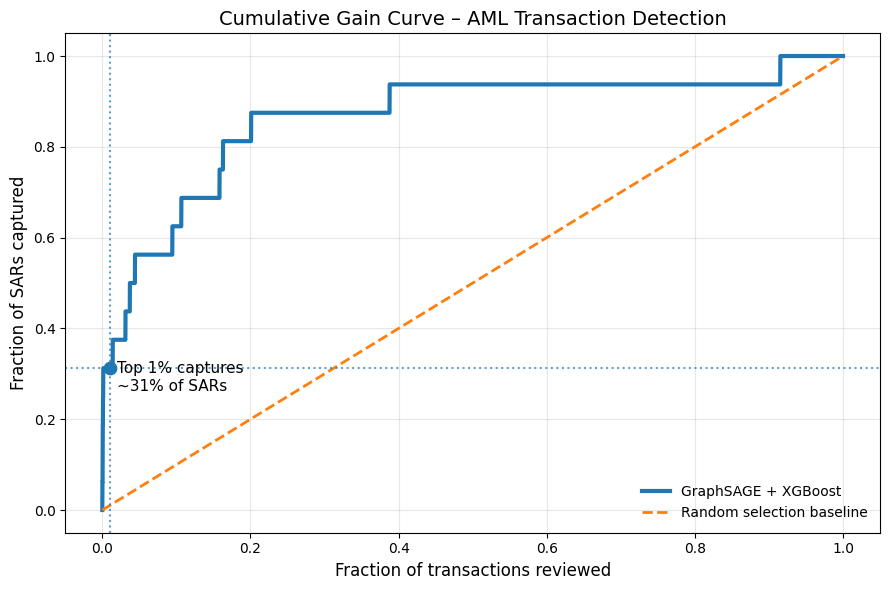

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Data
cum_sar = np.cumsum(results_df["y_true"])
total_sar = cum_sar.iloc[-1]
cum_recall = cum_sar / total_sar
x = np.arange(len(cum_recall)) / len(cum_recall)

# Plot
plt.figure(figsize=(9, 6))

# Model curve
plt.plot(
    x, cum_recall,
    linewidth=3,
    label="GraphSAGE + XGBoost",
)

# Random baseline
plt.plot(
    x, x,
    linestyle="--",
    linewidth=2,
    label="Random selection baseline"
)

# Highlight top 1%
k = 0.01
k_idx = int(len(x) * k)
plt.scatter(
    x[k_idx], cum_recall.iloc[k_idx],
    s=80,
    zorder=5
)
plt.axvline(k, linestyle=":", alpha=0.7)
plt.axhline(cum_recall.iloc[k_idx], linestyle=":", alpha=0.7)

plt.text(
    k + 0.01,
    cum_recall.iloc[k_idx] - 0.05,
    f"Top 1% captures\n~{cum_recall.iloc[k_idx]*100:.0f}% of SARs",
    fontsize=11
)

# Styling
plt.title("Cumulative Gain Curve – AML Transaction Detection", fontsize=14)
plt.xlabel("Fraction of transactions reviewed", fontsize=12)
plt.ylabel("Fraction of SARs captured", fontsize=12)

plt.legend(frameon=False)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()